In [ ]:
# Goal: learn a feedforward network's parameters such that the 

In [918]:
# Adapted from: https://github.com/HIPS/autograd/blob/master/examples/neural_net.py

import autograd.numpy as np
import autograd.numpy.random as npr
from autograd import grad
from autograd.util import quick_grad_check

class WeightsParser(object):
    """A helper class to index into a parameter vector."""
    def __init__(self):
        self.idxs_and_shapes = {}
        self.N = 0

    def add_weights(self, name, shape):
        start = self.N
        self.N += np.prod(shape)
        self.idxs_and_shapes[name] = (slice(start, self.N), shape)

    def get(self, vect, name):
        idxs, shape = self.idxs_and_shapes[name]
        return np.reshape(vect[idxs], shape)

    
def linear_loss(d_close,d_far):
    ''' we want a higher penalty value when d_close > d_far '''
    return d_close - d_far

def linear_loss_normed(d_close,d_far):
    ''' we want a higher penalty value when d_close > d_far '''
    return (d_close - d_far) / (d_close + d_far)

def exp_loss(d_close,d_far,scale=5.0):
    sign = d_close >= d_far
    
    return (2*sign-1)*np.exp(scale*np.abs(d_close - d_far))



def make_nn_funs(layer_sizes, activation=np.tanh, loss_fxn=linear_loss,ortho_penalty_param=0.01):
    parser = WeightsParser()
    for i, shape in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        parser.add_weights(('weights', i), shape)
        parser.add_weights(('biases', i), (1, shape[1]))

    def predictions(W_vect, X):
        """Outputs normalized log-probabilities."""
        cur_units = X
        N_iter = len(layer_sizes) - 1
        for i in range(len(layer_sizes) - 1):
            cur_W = parser.get(W_vect, ('weights', i))
            cur_B = parser.get(W_vect, ('biases', i))
            cur_units = np.dot(cur_units, cur_W) + cur_B
            cur_units = activation(cur_units)
        return cur_units
    
    def distance(x,y):
        return np.sqrt(np.dot(x-y,x-y))
    
    def orthonormal_columns_penalty(A):
        return np.sum(np.abs(np.dot(A.T,A) - np.eye(A.shape[1]))**2)
    
    def loss(W_vect, X_triplet,penalty_param=ortho_penalty_param):
        y,y_close,y_far = predictions(W_vect,X_triplet)
        d_close = distance(y,y_close)
        d_far = distance(y,y_far)
        
        ortho_penalty = 0
        if penalty_param>0:
            for i in range(len(layer_sizes)-1):
                ortho_penalty += penalty_param*orthonormal_columns_penalty(parser.get(W_vect, ('weights',i)))
        
        return loss_fxn(d_close,d_far) + ortho_penalty
        
        #log_prior = -L2_reg * np.dot(W_vect, W_vect)
        #log_lik = d_close - d_far
        
        #return - log_prior - log_lik

    return parser.N, predictions, loss

In [896]:
layer_sizes = [10,2]

n_weights,pred_fun,loss_fun = make_nn_funs(layer_sizes,activation = lambda i:i)

In [897]:
pred_fun(npr.randn(n_weights),(npr.randn(10),npr.randn(10),npr.randn(10)))

array([[-3.84646683, -4.40315676],
       [-0.71020318,  1.10246655],
       [ 0.95514462, -1.4744657 ]])

In [898]:
def tripletify_trajectory(X,tau_1=5,tau_2=20):
    X_triplets = []
    for i in range(len(X) - tau_2):
        X_triplets.append((X[i],X[i+tau_1],X[i+tau_2]))
    return X_triplets

In [170]:
from msmbuilder.example_datasets import FsPeptide
fs = FsPeptide().get()

from msmbuilder.featurizer import DihedralFeaturizer
dhft = DihedralFeaturizer().fit_transform(fs.trajectories)

loading trajectory_1.xtc...
loading trajectory_10.xtc...
loading trajectory_11.xtc...
loading trajectory_12.xtc...
loading trajectory_13.xtc...
loading trajectory_14.xtc...
loading trajectory_15.xtc...
loading trajectory_16.xtc...
loading trajectory_17.xtc...
loading trajectory_18.xtc...
loading trajectory_19.xtc...
loading trajectory_2.xtc...
loading trajectory_20.xtc...
loading trajectory_21.xtc...
loading trajectory_22.xtc...
loading trajectory_23.xtc...
loading trajectory_24.xtc...
loading trajectory_25.xtc...
loading trajectory_26.xtc...
loading trajectory_27.xtc...
loading trajectory_28.xtc...
loading trajectory_3.xtc...
loading trajectory_4.xtc...
loading trajectory_5.xtc...
loading trajectory_6.xtc...
loading trajectory_7.xtc...
loading trajectory_8.xtc...
loading trajectory_9.xtc...


In [899]:
tau_1 = 1
tau_2 = 100
triplets = [tripletify_trajectory(dhft_,tau_1,tau_2) for dhft_ in dhft]

In [900]:
X = np.vstack(triplets)

In [1011]:
X.shape

(277200, 3, 84)

In [902]:
n_dihedrals = X.shape[-1]

In [1006]:
#layer_sizes = [n_dihedrals,int(n_dihedrals/2),int(n_dihedrals/4),2]
#layer_sizes = [n_dihedrals,n_dihedrals*2,n_dihedrals,n_dihedrals/2,2]
layer_sizes = [n_dihedrals,20,5]

def relu(X):
    X[X<0]=0
    return X

def softplus(x):
    return np.log(1+np.exp(x))

n_weights,pred_fun,loss_fun = make_nn_funs(layer_sizes,activation=relu,loss_fxn=linear_loss_normed,ortho_penalty_param=0)

In [1013]:
X[X<0].shape

(36826562,)

In [1007]:
layer_sizes,n_weights

([84, 20, 5], 1805)

In [1008]:
grad_loss = grad(loss_fun)

In [1009]:
grad_loss(npr.randn(n_weights),X[0])

TypeError: only integer arrays with one element can be converted to an index

In [987]:
%timeit grad_loss(npr.randn(n_weights),X[0])

1000 loops, best of 3: 1.59 ms per loop


In [988]:
n_iter=1000
npr.seed(0)
weights = np.zeros((n_iter,n_weights))
weights[0] = npr.randn(n_weights)

In [989]:
step_size=1.0
for i in range(1,n_iter):
    weights[i] = weights[i-1] - step_size*np.nan_to_num(grad_loss(weights[i-1],X[npr.randint(len(X))]))

In [990]:
weights

array([[ 1.76405235,  0.40015721,  0.97873798, ...,  1.43156776,
         1.46221417, -0.42870207],
       [ 1.7560127 ,  0.39083287,  0.97882737, ...,  1.43156776,
         1.45420547, -0.42870446],
       [ 1.75680603,  0.38749387,  0.97813453, ...,  1.43156779,
         1.45424372, -0.42872442],
       ..., 
       [ 1.62894033,  0.43168693,  1.06436308, ...,  1.62278761,
         1.417201  , -0.4490802 ],
       [ 1.6269541 ,  0.43369359,  1.06435977, ...,  1.62278761,
         1.417201  , -0.4490802 ],
       [ 1.6269541 ,  0.43369359,  1.06435977, ...,  1.62278761,
         1.417201  , -0.4490802 ]])

In [991]:
grad_loss(weights[-1],X[0])

array([ -1.01046198e-02,   2.97639452e-04,  -9.63323340e-04, ...,
         0.00000000e+00,  -4.21481065e-11,  -7.88687185e-33])

In [992]:
weights[-1]

array([ 1.6269541 ,  0.43369359,  1.06435977, ...,  1.62278761,
        1.417201  , -0.4490802 ])

In [993]:
import matplotlib.pyplot as plt
%matplotlib inline

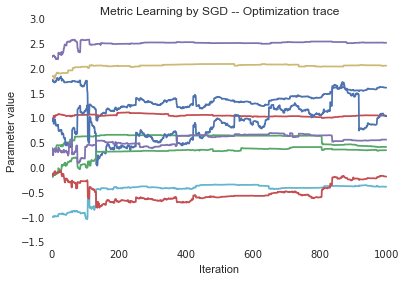

In [994]:
plt.plot(weights[:,:10]);
plt.xlabel('Iteration')
plt.ylabel('Parameter value')
plt.title('Metric Learning by SGD -- Optimization trace')

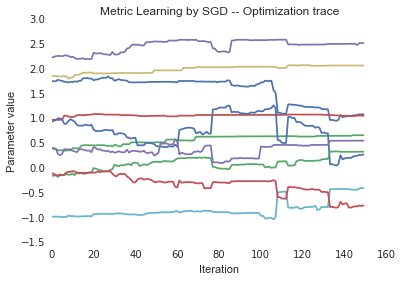

In [995]:
plt.plot(weights[:150,:10]);
plt.xlabel('Iteration')
plt.ylabel('Parameter value')
plt.title('Metric Learning by SGD -- Optimization trace')

In [952]:
diff = weights[1:] - weights[:-1]
diff.shape,np.abs(diff).sum(0).shape

((9999, 425), (425,))

In [891]:
diff

array([[ -4.68389262e-01,   3.40097909e-01,  -3.98393995e-01, ...,
          2.04713745e-02,   0.00000000e+00,   0.00000000e+00],
       [  4.70793563e-01,   1.16956504e-01,  -7.14695037e-02, ...,
          1.48642235e-01,   0.00000000e+00,   0.00000000e+00],
       [  9.47674952e-02,   3.07509866e-02,   4.03671317e-01, ...,
          2.80965883e-01,   0.00000000e+00,   1.11022302e-16],
       ..., 
       [ -1.10915245e-01,  -1.66359252e-02,  -1.92733994e-03, ...,
          2.62260535e-03,   0.00000000e+00,   0.00000000e+00],
       [  9.95049855e-03,  -2.09815702e-02,   2.90700833e-02, ...,
         -6.39944297e-02,   0.00000000e+00,  -5.55111512e-17],
       [  5.15523478e-04,   1.22038988e-02,   1.38114117e-02, ...,
         -4.69400129e-02,   0.00000000e+00,   0.00000000e+00]])

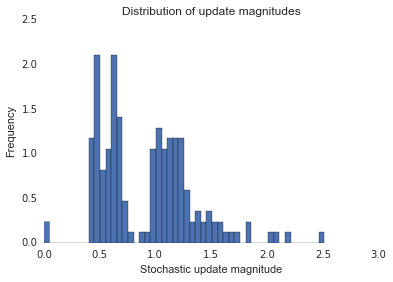

In [724]:
plt.hist(np.abs(diff).sum(0)/n_weights,bins=50,normed=True);
plt.xlabel('Stochastic update magnitude')
plt.ylabel('Frequency')
plt.title('Distribution of update magnitudes')

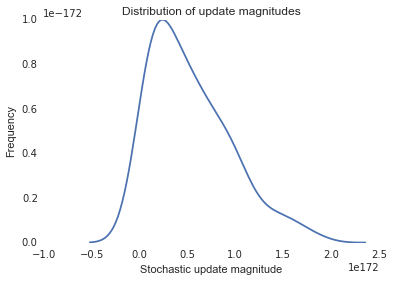

In [703]:
import seaborn as sns
sns.kdeplot(np.abs(diff).sum(0)/n_weights)
plt.xlabel('Stochastic update magnitude')
plt.ylabel('Frequency')
plt.title('Distribution of update magnitudes')

In [742]:
def batch_loss(w,X,loss_fun=loss_fun):
    return sum([loss_fun(w,x) for x in X])

In [663]:
from time import time
t = time()
batch_loss(weights[0],X)
t1 = time()
print(t1-t)

KeyboardInterrupt: 

In [740]:
npr.seed(0)
sample_size=100000
mask = npr.randint(0,len(X),sample_size)
X_sample = X[mask]

In [764]:
batch_loss(weights[0],X_sample),batch_loss(weights[-1],X_sample)

(15316084.544059236, -11161.710785435955)

In [667]:
npr.seed(0)
sample_size=10000
mask = npr.randint(0,len(X),sample_size)
X_sample = X[mask]

In [668]:
from time import time
t = time()
batch_loss(weights[0],X_sample)
t1 = time()
print(t1-t)

0.332966089249


In [669]:
len(weights[:1000][::10])

100

In [705]:
losses = [batch_loss(w,X_sample) for w in weights[:1000][::10]]
plt.plot(losses)

KeyboardInterrupt: 

In [616]:
print(fs.DESCR)

This dataset consists of 28 molecular dynamics trajectories of Fs peptide
(Ace-A_5(AAARA)_3A-NME), a widely studied model system for protein folding.
Each trajectory is 500 ns in length, and saved at a 50 ps time interval (14
us aggegrate sampling). The simulations were performed using the AMBER99SB-ILDN
force field with GBSA-OBC implicit solvent at 300K, starting from randomly
sampled conformations from an initial 400K unfolding simulation. The
simulations were performed with OpenMM 6.0.1.

The dataset, including the script used to generate the dataset
is available on figshare at

http://dx.doi.org/10.6084/m9.figshare.1030363



ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

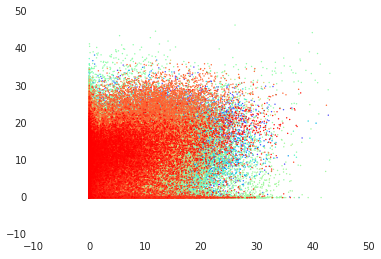

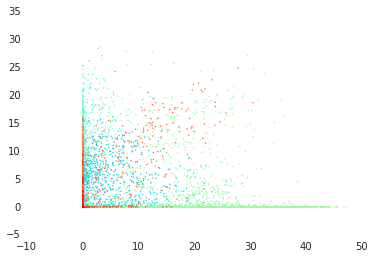

In [996]:
# before training
X_pred = pred_fun(weights[0],X[:,0,:])
plt.scatter(X_pred[:,0],X_pred[:,1],linewidths=0,s=2,c=np.arange(len(X_pred)),cmap='rainbow')

plt.figure()

# after training: : tau_1 = 1, tau_2 = 100, 
# layer_sizes = [n_dihedrals,2]
# activation=lambda i:i,loss_fxn=linear_loss_normed,ortho_penalty_param=0)
X_pred = pred_fun(weights[-1],X[:,0,:])
plt.scatter(X_pred[:,0],X_pred[:,1],linewidths=0,s=2,c=np.arange(len(X_pred)),cmap='rainbow')

from sklearn.decomposition import PCA

plt.figure()
X_pred = PCA(2).fit_transform(pred_fun(weights[-1],X[:,0,:]))
plt.scatter(X_pred[:,0],X_pred[:,1],linewidths=0,s=2,c=np.arange(len(X_pred)),cmap='rainbow')

array([ True, False, False, ..., False, False, False], dtype=bool)

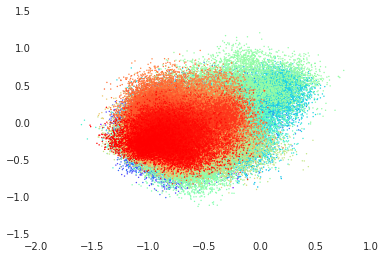

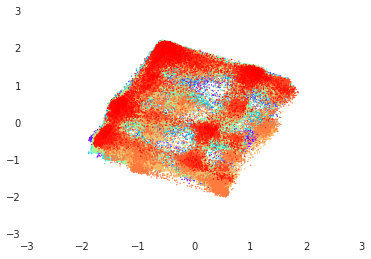

In [636]:
# before training
X_pred = pred_fun(weights[0] / np.sum(weights[0]),X[:,0,:])
plt.scatter(X_pred[:,0],X_pred[:,1],linewidths=0,s=2,c=np.arange(len(X_pred)),cmap='rainbow')

plt.figure()

# after training
X_pred = pred_fun(weights[-1] / np.sum(weights[-1]),X[:,0,:])
plt.scatter(X_pred[:,0],X_pred[:,1],linewidths=0,s=2,c=np.arange(len(X_pred)),cmap='rainbow')

In [637]:
from msmbuilder.decomposition import tICA
tica = tICA(2,10)

In [638]:
X_tica = np.vstack(tica.fit_transform(dhft))

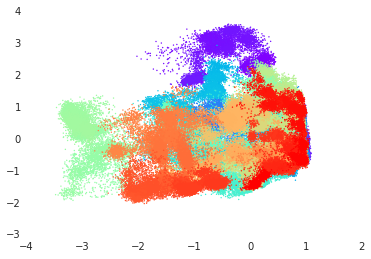

In [639]:
plt.scatter(X_tica[:,0],X_tica[:,1],linewidths=0,s=2,c=np.arange(len(X_tica)),cmap='rainbow')

In [954]:
from msmbuilder.cluster import MiniBatchKMeans
from msmbuilder.msm import MarkovStateModel
from sklearn.pipeline import Pipeline

results = dict()
embeddings = [('tICA',X_tica),('Triplet',X_pred)]
for (name,dataset) in embeddings:
    pipeline = Pipeline([
        ('cluster', MiniBatchKMeans(n_clusters=200)),
        ('msm', MarkovStateModel(lag_time=10))
    ])
    pipeline.fit([dataset[:100000]])
    results[name] = pipeline
    print(name,pipeline.score([dataset[100000:]]))

MSM contains 1 strongly connected component above weight=0.10. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.10. Component 0 selected, with population 100.000000%
('tICA', 8.2966074848973896)
MSM contains 1 strongly connected component above weight=0.10. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.10. Component 0 selected, with population 100.000000%
('Triplet', 7.3742643165105912)
